# Infering Prior Distribution
Miguel Fuentes  
Created: 4/29/2020  
Last Updated: 5/4/2020

In [1]:
%matplotlib inline
from infection_models import sample_transmission

from collections import namedtuple

import matplotlib.pyplot as plt

import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## Conditioned Distribution and Guide Function
I will do inference about the sample_transmission model conditioned on someone who is not following social distancing. This model is basically just a data generation scheme since it doesn't observe any data to update its paramaters. On top of that, the guide function I chose draws the latent variables from the same distributions as the original model does. Therefore this task is basically seeking to use SVI to infer the parameters of the prior distribution for infected people behaving normally. 

In [2]:
conditioned_individual = pyro.condition(sample_transmission, data={'protocol': torch.tensor(1.0)})

def parametrized_guide_constrained():
    rate_contacted = pyro.param('rate_contacted', torch.tensor(10.), constraint=constraints.positive)
    contacted_people = pyro.sample('contacted_people', pyro.distributions.Poisson(rate_contacted))
    
    infection_conc_0 = pyro.param('infection_conc_0', torch.tensor(15.0), constraint=constraints.positive)
    infection_conc_1 = pyro.param('infection_conc_1', torch.tensor(15.0), constraint=constraints.positive)
    infection_rate = pyro.sample('infection_rate', pyro.distributions.Beta(infection_conc_1, infection_conc_0))

    rate_num_infected = contacted_people * infection_rate
    num_infected = pyro.sample('num_infected', pyro.distributions.Poisson(rate_num_infected))

## Optimization
Here I run SVI with some basic optimizer settings and track the paramater updates at every step of the process. At the end, I plot the ELBO (technically -ELBO) along with the change in the paramaters. The final paramaters should be close to or equivalent to the priors.

rate_contacted:  105.30087280273438
infection_conc_0:  26.269180297851562
infection_conc_1:  6.76555061340332


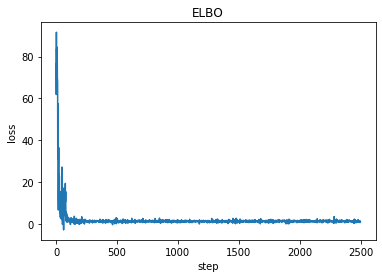

In [3]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_individual,
                     guide=parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, rate_contacted, infection_conc_0, infection_conc_1  = [], [], [], []
num_steps = 2500
for _ in range(num_steps):
    losses.append(svi.step())
    rate_contacted.append(pyro.param('rate_contacted').item())
    infection_conc_0.append(pyro.param('infection_conc_0').item())
    infection_conc_1.append(pyro.param('infection_conc_1').item())
    

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('rate_contacted: ',pyro.param('rate_contacted').item())
print('infection_conc_0: ',pyro.param('infection_conc_0').item())
print('infection_conc_1: ',pyro.param('infection_conc_1').item())

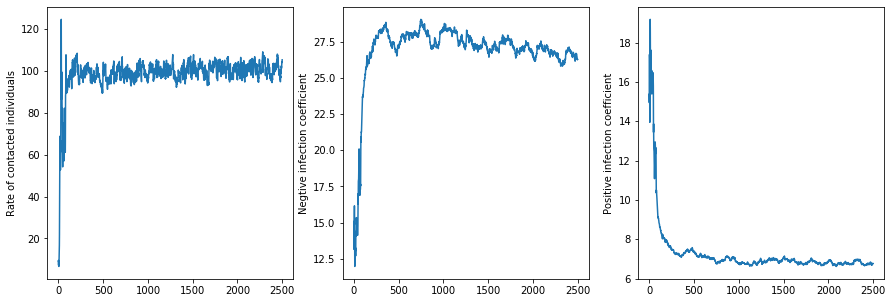

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].set_ylabel('Rate of contacted individuals')
axs[0].plot(rate_contacted)

axs[1].set_ylabel('Negtive infection coefficient')
axs[1].plot(infection_conc_0)

axs[2].set_ylabel('Positive infection coefficient')
axs[2].plot(infection_conc_1)

## Conclusion
I'm not really sure why the guide paramaters don't really settle that close to the prior distribution. I wonder if the parameters that this comes up with end up being equivalent to the prior parameters in the end (maybe fewer people get infected but more people are contacted or vice-versa so the num_infected is similar). That is the only thing I can really think of, but that doesn't really make sense because the loss should take into accound the distributions of the other latent variables too  
**EDIT**  
I just realized why the model doesn't learn the prior distribution - the prior is also defined by paramaters so they also get gradient updates. The paramaters both move towards each other!!! That's why the results didn't make sense!!!